# Workshop: Assumptions, Diagnostics and Transformations
In the accompanying lesson to this workshop we explored the topic of model assumptions, diagnostic measures and transformations. Checking model assumptions is an essential part of building a statistical model, but is often one that is poorly addressed in practice. In part, this can comes down to misunderstandings of the assumptions themseleves (e.g. checking the distribution of the entire outcome variable), an over-reliance on inferential tests of assumptions, or a lack of knowledge around what to do if assumptions are violated. In this workshop, the aim is to provide more information around diagnostic plots, the use of polynomial regression to address non-linearity and, of most importance, alternative models that can be used to address assumnptions violations. This final topic is incredibly powerful because, as we saw in the lesson, transformations are often ineffective and cause issues with interpretation. As such, the alternative is to use different models that allow for more flexibility around certain assumptions. These alternatives have their own disadvantages, but are often the most elegant way to address assumption violations.

## Diagnostic Plots
To begin with, we will focus on the topic of diagnostic plots of the assumptions. Generally speaking, the standard plots created by `R` when calling `plot(mod)` are all that you need to assess a linear model. In the accompanying lesson, we saw the standard 4 plots created with this method. However, there are some additional plots that can be useful to see various assumptions or data features more clearly. Here, we will have a brief rundown of some of the more useful.

### Correlation Plots
Although previously we indicated that assessing correlation between predictors is best served by the VIF, it can be useful at times to investigate correlation as part of the initial descriptive exploration of the data, prior to fitting any model. For that purpose, a correlation plot can be useful. In the example below, we use the `corrplot` package to visualise the entire `mtcars` dataset.

corrplot 0.95 loaded



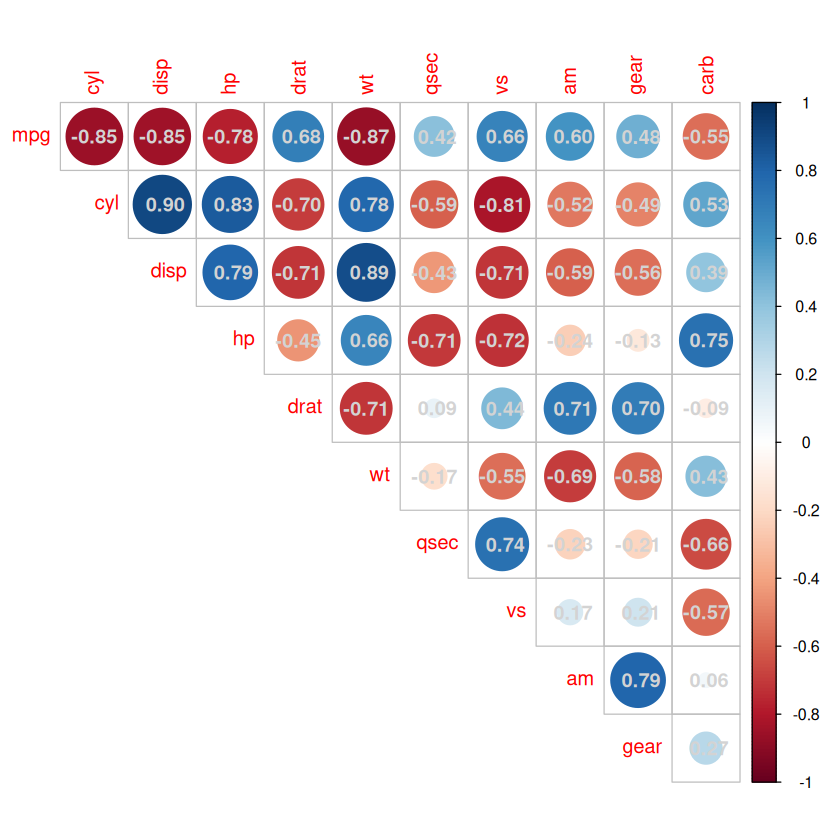

In [1]:
library('corrplot')
data(mtcars)
corrplot(cor(mtcars), 
        type='upper',            # just upper-diagonal
        addCoef.col='lightgrey', # add coeficient labels
        diag=FALSE)              # hide diagonal

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 1</b> Have a look at all the options available by typing <code>?corrplot</code> and skimming through the documentation. Have a go at changing some of these.
</div>

Using the options specified in the original code above, there are several useful visual indicators here to alert us to problems. Firstly, the size of the circle is indicative of the magnitude of the correlation, so bigger circles are more of a warning than smaller circles. The *transparency* of the circles is also indicative of the magnitude, so this is a useful visual way of drawing our attention to larger correlations. Finally, the colour of the circles is indicative of the *direction* of the correlation, so that red shows *negative* and blue shows *positive*. 

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 2</b> Using <code>mpg</code> as the outcome variable,  which row/column of the correlation plot should we focus on to indicate <i>which</i> predictor variables may be of most interest? For each chosen predictor variables, how could we then use the correlation plot to assess whether multicollinearity might be a problem?
</div>

We can also see these relationships in terms of the actual data using a *pairs plot* 

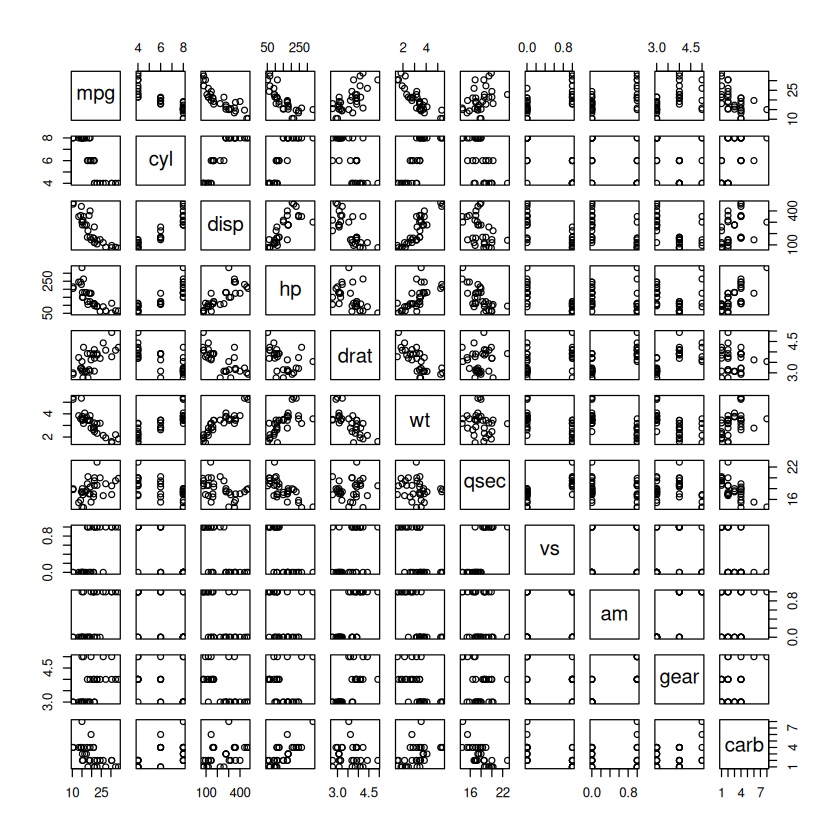

In [2]:
pairs(mtcars)

On its own, this will plot *everything* in the data frame, which can be difficult to see. We can be more specific by providing a formula, just like `lm()`

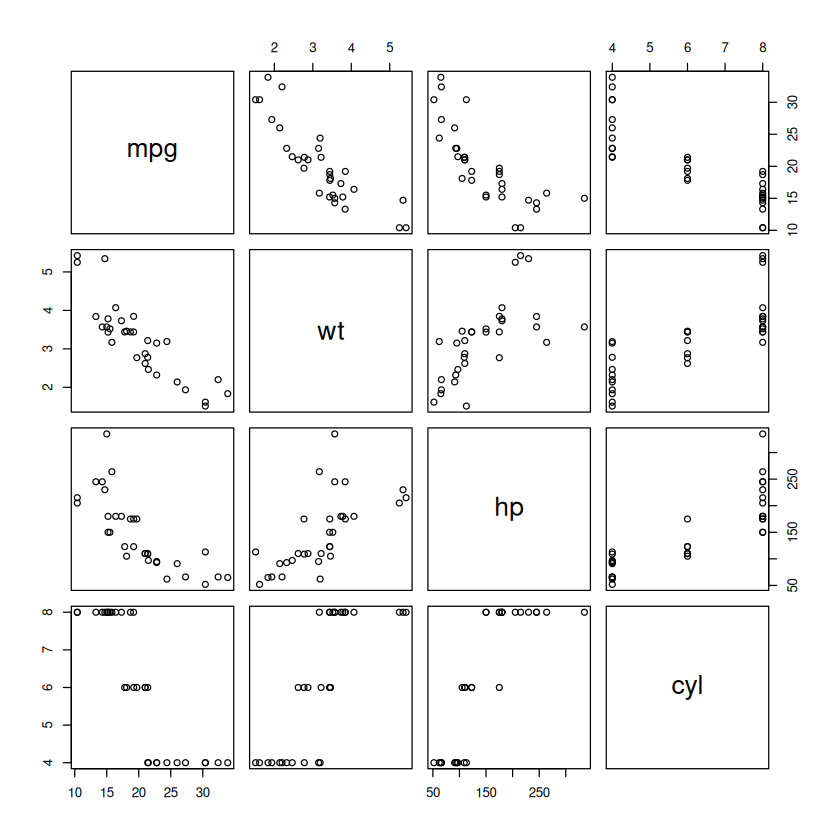

In [3]:
pairs(mpg ~ wt + hp + cyl, data=mtcars)

So now we can eye ball the relationships between the outcome and predictors, as well as the relationships *between* the predictors. Remember, these are not corrected for each other and so may not represent the result we would get from a multiple regression. As such, this plot is more akin to multiple *simple* regression models.

### VIF Barplot
As part of the accompanying lesson, we discussed the VIF and how to produce VIF values. However, it can be useful to visualise these as a bar chart with standard cut-offs of 5 and 10. In the example below, we include the same `wt.copy` variable as used in the lesson to simulate multicollinearity.

Loading required package: carData



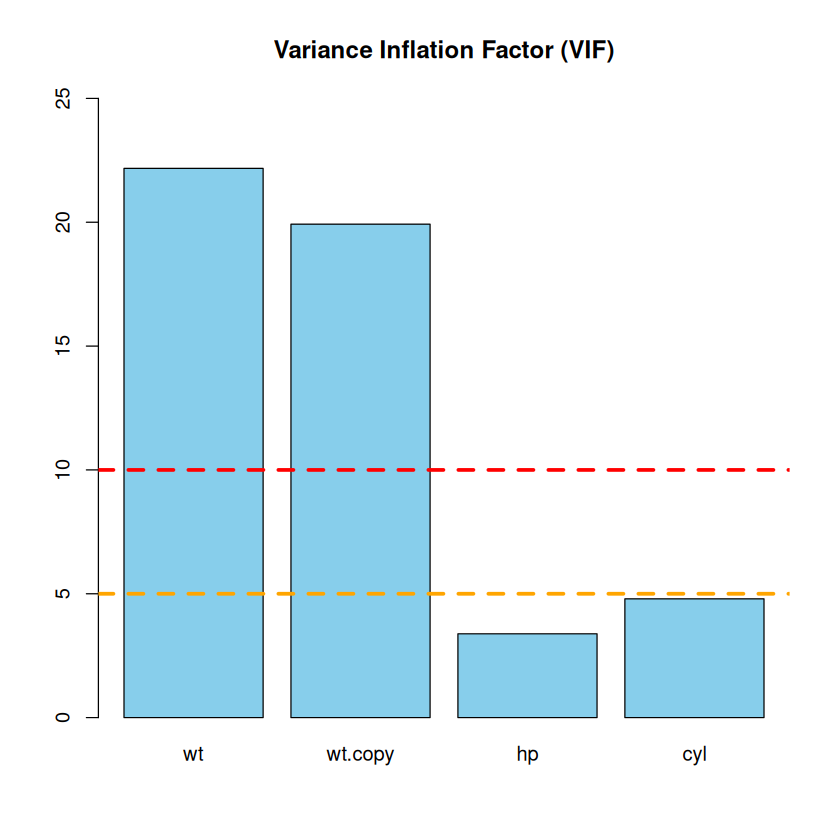

In [4]:
library(car)
set.seed(666)
wt           <- mtcars$wt
wt.copy      <- wt + rnorm(n=length(wt), mean=0, sd=0.2)        # wt + random noise
mod.multicol <- lm(mpg ~ wt + wt.copy + hp + cyl, data=mtcars)
vif.values   <- vif(mod.multicol)

barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,25))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 3</b> Use the code above to draw this chart again after removing <code>wt</code> from the model and then do this again after removing <code>wt.copy</code> from the model. Keep the <code>ylim=c(0,25)</code> argument the same so you can directly compare the plots. Based on this, can we use VIF to tell us <i>which</i> predictor to remove from the model? What does this imply about the role of the analyst in the process of model building?
</div>

### Influence Plot
Another useful plot included as part of the `car` package is the *influence* plot, where studentised residuals, leverage, Cook's distance and standard thresholds for extreme points are all combined into the same plot. As an example:

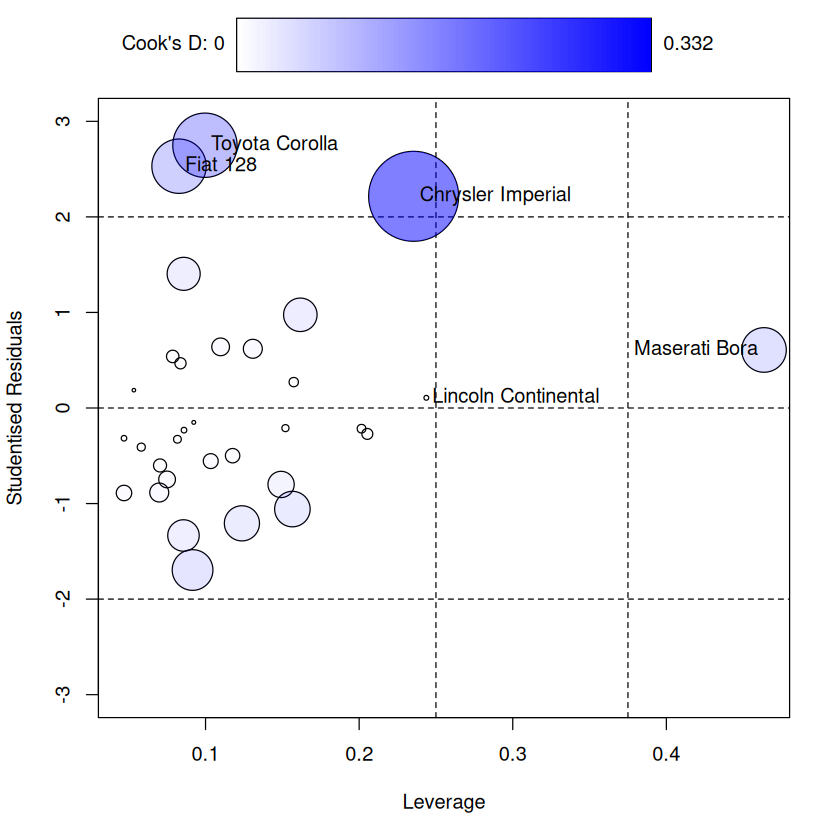

In [5]:
mod     <- lm(mpg ~ wt + hp + cyl, data=mtcars)
notable <- influencePlot(mod, xlab="Leverage", ylab="Studentised Residuals", ylim=c(-3,3))

Here we can see leverage plotted against the *studentised* residuals, with the magnitude of Cook's Distance displayed as bubbles of different sizes around each point. The mapping between these bubbles and Cook's Distance is shown by the colour bar at the top. Looking at the top value of the colour map, we can see it is below our lower heuristic of $D > 0.5$, meaning we have little concern here in terms of Cook's distance. In addition, heuristics of 2 and -2 are shown vertically for outliers, with heuristics of $2\frac{p}{n}$ and $3\frac{p}{n}$ shown horizontally for leverage. Notable points have also been labelled and are returned as a data frame

In [6]:
print(notable)

                      StudRes        Hat        CookD
Lincoln Continental 0.1065775 0.24373270 0.0009486833
Chrysler Imperial   2.2153833 0.23547715 0.3316313326
Fiat 128            2.5303244 0.08274176 0.1210330843
Toyota Corolla      2.7498370 0.09961207 0.1694339333
Maserati Bora       0.6073374 0.46356582 0.0815260489


How these points are chosen requires a little explanation. The labels are based on the top two points for each of the influence measures. For the studentised residuals, the two largest points are `Toyota Corolla` and `Fiat 128`. For the leverage values, the two largest points are `Maserati Bora` and `Lincoln Continental`. For Cook's Distance, the two largest points are `Chrysler Imperial` and `Toyota Corolla`. So this gives five unique data points (because `Toyota Corolla` appears *twice*). The labelling in the plot can then be thought of as the two largest values horizontally, the two largest vertically, and the two largest in terms of their bubble size. Of note is that this will happen irrespective of whether any of the data points are above any threshold of concern on any measure. For instance, none of these data have $D_{i} > 0.5$, despite the function still labelling the top two values.

## Polynomial Regression
One of the core assumptions of a basic regression model is that a stright-line is an accurate representation of the relationship in the data. If this is not the case, then nothing else matters in terms of the model assumptions. In the accompanying lesson, we introduced polynomial regression as a solution when a straight-line did not appear to fit the data well. This is one of the most powerful options available to you to allow much more complex relationships between variables to be captured within a regression framework. In the lesson, we made use of the `poly()` function, but it is worth spending a little more time understanding *why* this was used. 

### Including Different Powers Directly
To illustrate why we use the `poly()` function, we will first start with a basic polynomial model of `wt`. For the sake of argument, we will say that through our diagnostic investigations we have decided that a polynomial of degree 2 would be a good idea (also known as a *quadratic* polynomial). The theoretical model for this would be

$$
y_{i} = \beta_{0} + \beta_{1}x_{i} + \beta_{2}x^{2}_{i} + \epsilon_{i}.
$$

So, it looks like we can just enter `wt` and `wt^2` into the model formula and be done. However, there are two issues with this. The first is a purely `R`-specific issue, and the second is much more general.

In terms of the first issue, to include transformations directly in an `R` formula, we need to use the `I()` function. This tells `R` to treat whatever is inside the brackets *literally*. This is needed because many common symbols have special meanings inside an `R` formula. So this function can be taken to mean *`I`nhibit* the formula interpretation. For example, we would usually use the caret symbol to indicate raising a variable to a power (e.g. `x^2`). However, the symbol `^` means something else in an `R` formula and this will not work.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 4</b> Try specifying the model <code>mpg ~ wt + wt^2</code>. What does this do? Does it do what you expected?
</div>

Instead, we need to wrap `wt^2` inside `I()`. This will tell `R`: *treat this symbol as its usual meaning, not the special formula meaning*. For example

In [7]:
poly.mod <- lm(mpg ~ wt + I(wt^2), data=mtcars)
print(poly.mod)


Call:
lm(formula = mpg ~ wt + I(wt^2), data = mtcars)

Coefficients:
(Intercept)           wt      I(wt^2)  
     49.931      -13.380        1.171  



This solves our first problem and seemingly has allowed us to fit the polynomial model. However, to understand the second problem, let us have a look at the VIF values

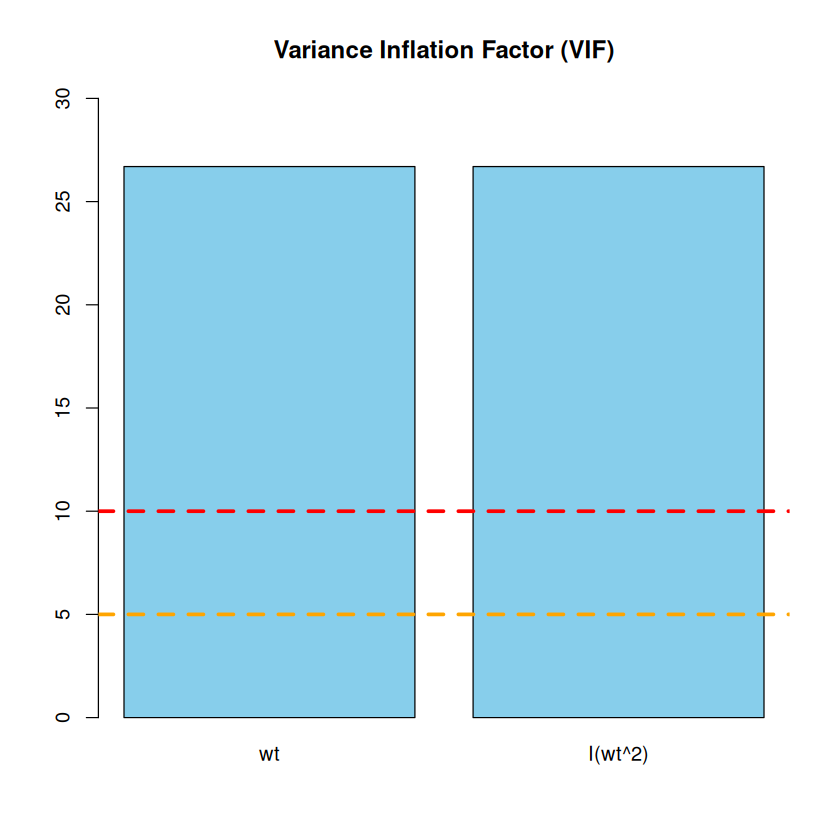

In [8]:
vif.values <- vif(poly.mod)
barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,30))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

So now we can see the other issue more clearly. Including both `wt` and `wt^2` causes a massive multicollinearity problem.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 5</b> Before reading on, can you think what might be causing this result? Could you use some of the plots from earlier to investigate this further?
</div>

### Orthogonal Polynomials
Hopefully it is clear that raising a variable to any power will make it highly correlated with the original variable. Having both in the model will then causes multicollinearity issues. However, we need both because the two terms serve different geometric purposes. The quadratic term introduces a bend in the relationship, but the linear term allows that bend to be offset and tilted. We cannot just include $x^{2}$ because that would only fit a parabola to the data. So, in order to include both terms we need to use *orthogonal polynomials*. This is what the `poly()` function creates for us. In this context, *orthogonal* can be taken to mean *uncorrelated*. As an example, we can rerun the model above using `poly()` and then check the VIF.

In [9]:
poly.mod <- lm(mpg ~ poly(wt, degree=2), data=mtcars)
print(poly.mod)


Call:
lm(formula = mpg ~ poly(wt, degree = 2), data = mtcars)

Coefficients:
          (Intercept)  poly(wt, degree = 2)1  poly(wt, degree = 2)2  
               20.091                -29.116                  8.636  



Unfortunately, the `vif()` function from `car` gets a bit confused when we have `poly()` in the model formula, so we extract the predictors and then add them manually to get the VIF values. This is usually unnecessary, so it should only be needed for this demonstration

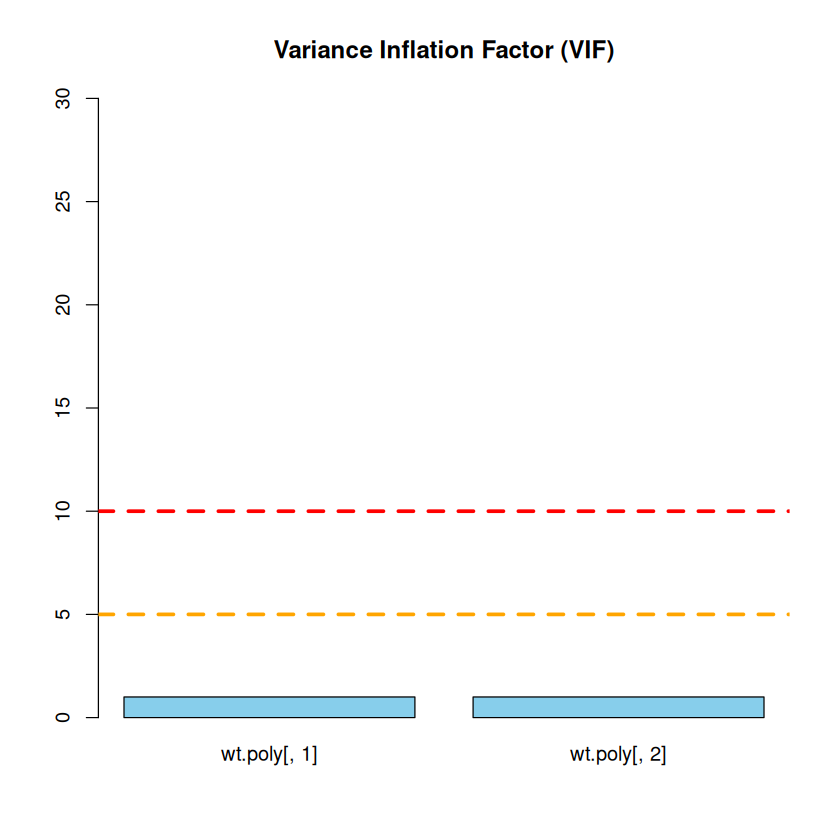

In [10]:
wt.poly      <- poly(mtcars$wt, degree=2)                        # polynomial predictors
poly.mod.alt <- lm(mpg ~ wt.poly[,1] + wt.poly[,2], data=mtcars) # add predictors manually
vif.values   <- vif(poly.mod.alt)

barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,30))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

As we can see, these predictors are *perfectly uncorrelated*. The VIF is 1 for each, meaning the variance is *not inflated at all* with either predictor in the model. This is the essence of two variables being *orthogonal*. We can also see this by calculating their correlation

In [11]:
cor(wt.poly[,1],wt.poly[,2])

[1] 5.514184e-19

which is basically *exactly 0*, as far as the computer is concerned.

## Alternative Models When Assumptions are Violated
As a final part in this workshop, we will consider a different solution to assumption violations. Rather than trying to transform our way out of a hole, we instead consider a different *model* that is able to more flexibly accommodate a particular assumption violation. Note that we are only giving an idea of each method below. Each one could encompass its own lesson and so there is much more to learn here. The aim is just to make you *aware* that these method exist. It is then up to you if you want to dig down and understand them further.

### Robust Regression for Outliers
Our first option is for dealing with *outliers*. Although we have several methods for detecting outliers, our approaches for dealing with them are quite limited. In general, we can either remove them or leave them in place. Removing them is an extreme measure that is only really justifiable when the data is unambiguously *wrong*. In most cases, we cannot make sure a strong claim. However, we know that leaving them can bias the regression model. So what can we do?

In cases where we are particularly worried about this, we can use a method known as *robust regression*. This is something of a catch-all term for a variety of different approaches, each with the aim of reducing the influence of outliers on the regression results. However, each method tends to be similar in that the problem is tackled by defining a set of *weights* that work to reduce the influence of individual data points. A weight is defined for each data point where a weight of 1 will simply include the original data point and a weight < 1 will reduce the magnitude of the data point. These weights are assigned using rules about the magnitudes of the residuals from the model fit, so there is an iterative approach here where the model is fit, weights are computed, the model is refit with the weights, the weights are then recomputed using the next set of residuals and so on. This will be continued until some stopping criteria is reached (usually related to the weights not changing meaningfully after each new iteration). The idea is simply to *down-weight* the influence of outliers on the model fit.

As an example, we will use the `lmrob()` function from the `robustbase` package. Much more can be learned about this method through its documentation, but we just illustrate the basic method here. We will show the difference against the standard `lm()` results below

In [12]:
library(robustbase)

robust.mod   <- lmrob(mpg ~ wt + hp + cyl, data=mtcars) # robust regression
unrobust.mod <-    lm(mpg ~ wt + hp + cyl, data=mtcars) # OLS regression

summary(robust.mod)
summary(unrobust.mod) 


Call:
lmrob(formula = mpg ~ wt + hp + cyl, data = mtcars)
 \--> method = "MM"
Residuals:
    Min      1Q  Median      3Q     Max 
-3.4606 -1.3597 -0.2818  1.2963  6.4483 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 37.846504   2.330256  16.241  8.8e-16 ***
wt          -3.114388   0.709847  -4.387 0.000148 ***
hp          -0.016532   0.008431  -1.961 0.059913 .  
cyl         -0.901334   0.473229  -1.905 0.067146 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Robust residual standard error: 2.211 
Multiple R-squared:  0.8425,	Adjusted R-squared:  0.8257 
Convergence in 12 IRWLS iterations

Robustness weights: 
 4 weights are ~= 1. The remaining 28 ones are summarized as
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3751  0.8905  0.9546  0.8927  0.9778  0.9955 
Algorithmic parameters: 
       tuning.chi                bb        tuning.psi        refine.tol 
        1.548e+00         5.000e-01         4.685e+00         1.


Call:
lm(formula = mpg ~ wt + hp + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9290 -1.5598 -0.5311  1.1850  5.8986 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 38.75179    1.78686  21.687  < 2e-16 ***
wt          -3.16697    0.74058  -4.276 0.000199 ***
hp          -0.01804    0.01188  -1.519 0.140015    
cyl         -0.94162    0.55092  -1.709 0.098480 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.512 on 28 degrees of freedom
Multiple R-squared:  0.8431,	Adjusted R-squared:  0.8263 
F-statistic: 50.17 on 3 and 28 DF,  p-value: 2.184e-11


Here we can see that both `hp` and `cyl` have changed the most dramatically. Focusing on `hp`, the standard error has reduced from `0.012` to `0.008` thanks to down-weighting the outliers. We can see some information about the weights in the output from `lmrob()`, where only 4 of the original data points remain un-weighted and the *smallest* weight is given by `0.3751`. This means that some data points have been shrunk to around 37% of their original value. These weights can be viewed using

In [13]:
print(robust.mod$rweights)

          Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
          0.9606454           0.9917463           0.8707532           0.9883181 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
          0.9486403           0.9387561           0.9747702           0.9768062 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
          0.9999322           0.9955010           0.9344154           0.9629984 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
          0.9707809           0.9912045           0.9954155           0.9991701 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
          0.6563780           0.4264125           0.9233249           0.3750911 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
          0.7892214           0.9472616           0.9072091           0.9674825 
   Pontiac Firebird         

So we can see that most data points are close to their original value, but notably the value for `Toyota Corolla` shows it has been dramatically down-weighted. So too have `Fiat 128` and `Chrysler Imperial`.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 6</b> Have a look back at some of the plots we made earlier. Does the selection of these points as targets for the most down-weighting track with what we already know? Can you order these weights from smallest to biggest so we can more easily identify which points have been shrunk the most?
</div>

Much like `lm()` we can create diagnostic plots for the robust regression, though these are different and are explained in more detail in the documentation (look up the method `plot.lmrob`). Because the `lmrob()` models exports the same standard methods as `lm()`, we can also create effects plots without any problems.

lattice theme set by effectsTheme()
See ?effectsTheme for details.



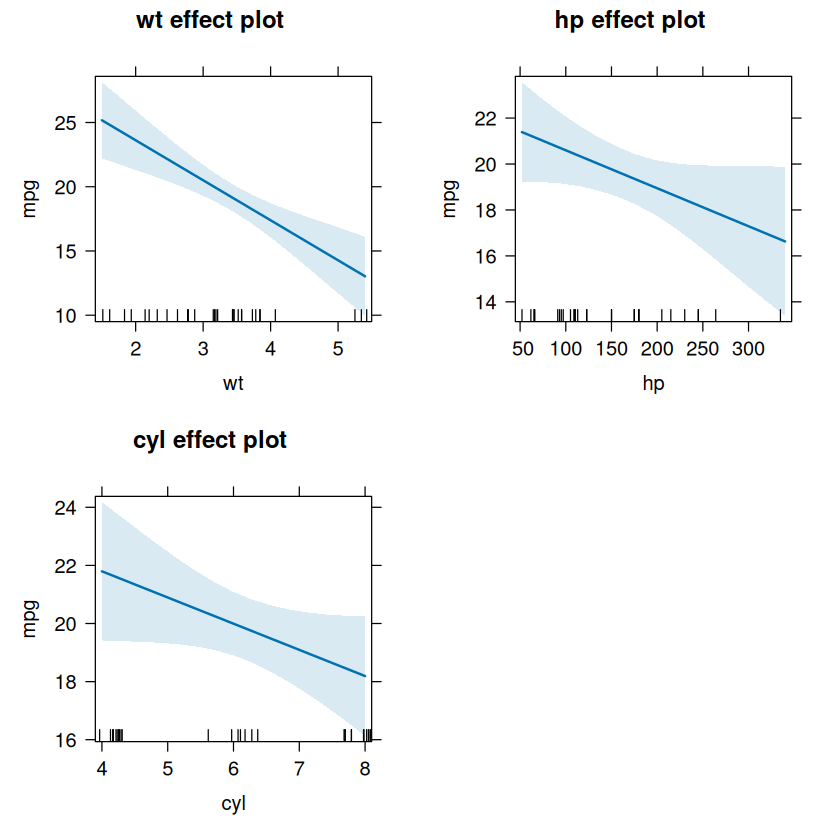

In [14]:
library(effects)
plot(allEffects(robust.mod))

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 7</b> The differences in slopes are very subtle in these plots, but have a look at the <i>confidence bands</i> around the slope for <code>hp</code> in the effects plots from the robust model. Can you compare these with the effects plots from the original <code>lm()</code> model? What is the main difference you can see?
</div>

Of importance is recognising that the inferential tests on the model parameters are *approximations* within the context of a robust model. So, we cannot treat them with quite the authority we do from `lm()`. Realistically, these should be considered *asymptotically correct*, meaning they will become more reliable the larger the sample size. Because of this, some implementations of robust regression will *refuse* to give you a $p$-value (e.g. `rlm()` from the `MASS` package). `lmrob()` does, but this is a bit controversial, so treat these results with *extreme caution*.

### Generalised Least-squares for Heteroscedasticity
Our second option is for dealing with non-constant variance (heteroscedasticity). For some regression problems, we may find that the variance is actually some function of the predictors (perhaps *increasing* or *decreasing* with values of $x$). In other problems we will see later, the use of a *categorical* predictor variable can show problems of heteroscedasticity if the groups have unequal variances. In all these cases, there is little we can do with a traditional regression model unless we can find some variance-stabilising transformation that renders the data homoscedastic. Otherwise, we have to accept that there may be some element of bias in our estimation and inference.

For cases where this is especially problematic, we can turn to the method of *generalised least squares* (GLS). This approach is, as the name suggests, a generalisation of the OLS regression model, but one where we can specify a more complex variance function. Recall from multiple regression that the variance function is simply $\sigma^{2}_{i} = \sigma^{2}$. In other words, a *constant variance* for every observation. However, in cases of heteroscedasticity, the variance changes depending upon the value of one or more of the predictor variables. In these situations, we can use GLS to estimate a model that takes this into account. In order to do this (and unlike the name implies) the method of Restricted Maximum Likelihood (REML) is used. Within `R`, we can use the `gls()` function from the `nlme` package to fit these types of models.

#### GLS for Simple Regression
For this first example we will simulate some data, given that there are no major heteroscedasticity issues in our `mtcars` model. For ease, we will look at simple regression and then discuss multiple regression below. 

In terms of simulating heteroscedasticity, we will use a *power function* of the following form

$$
\sigma_{i} = \sigma|x|^{\delta}.
$$

In words, the standard deviation of each observation comes from some base value of variation ($\sigma$) multiplied by the absolute value of the predictor ($|x|$) raised to some power $\delta$. The reason this model is used is because it is the simplest mathematical way of specifying the idea that the *spread* expands with increasing or decreasing values of $x$. If we set $\delta = 0$, then this just becomes a constant variance term. If $\delta < 0$ then the spread of data *decreases* as $x$ increases, whereas if $\delta > 0$ then the spread of data *increases* as $x$ increases. The mechanism that controls *how* this spread changes given the units of $x$ is the magnitude of $\delta$. For any given problem, $\delta$ can be tuned so that the characteristic funnel shape in the spread of the data becomes whatever we want. The absolute value is simply here to make sure variance is always *positive* and no imaginary numbers are created (e.g. `(-7)^(-1.2)`). 

In the simulation below, we arbitrarily set $\delta = 0.8$, but it does not really matter what this means. The main point is that this creates a *funnel* shape in the diagnostic plots that typifies some sort of unmodelled structure in the variance function.

In [15]:
set.seed(666)

n      <- 200           # 200 simulated values
x      <- runif(n,1,10) # generate some random predictor values 
beta.0 <- 1             # population intercept
beta.1 <- 2             # population slope
sigma  <- 0.5           # population baseline variance
delta  <- 0.8           # population exponent

# simulate increasing variance with x
sd.x    <- sigma * abs(x)^delta 
y       <- beta.0 + beta.1*x + rnorm(n, mean=0, sd=sd.x)
sim.dat <- data.frame("x.sim"=x, "y.sim"=y)

We can see this if we fit an OLS model to the simulated data and create the diagnostic plots.

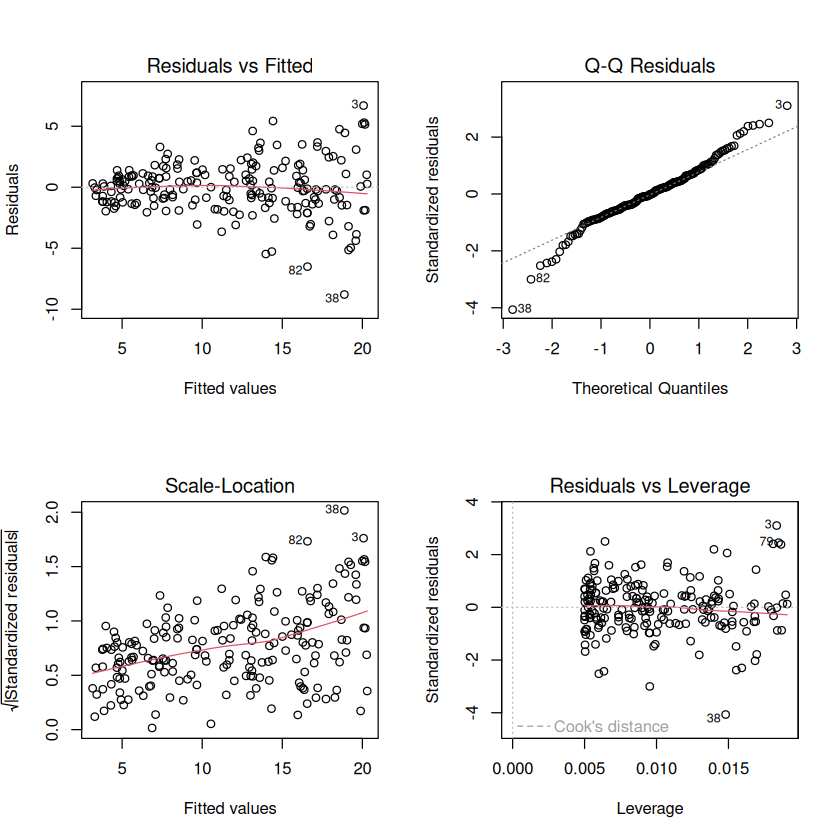

In [16]:
uneq.var.mod <- lm(y.sim ~ x.sim, data=sim.dat)
par(mfrow=c(2,2))
plot(uneq.var.mod)

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 8</b> Have a go at changing <code>delta</code> in the simulation code. Try values in the range -2 to +2. Can you get a sense of how flexible this framework is for understanding situations where the magnitude of the variance relates to the value of the predictor?
</div>

In order to fit a model that captures this variance structure, we use the `gls()` function. This has a very similar form to `lm()`, as it takes a formula for the model and a `data` argument. The main difference comes in the specification of a *variance function*, using the `weights` argument. This takes one of several pre-structured variance functions that come with `nlme` to capture different kinds of heteroscedastic patterns in the data. You can read about all of these by typing `?varClasses` at the prompt. 

For this example, we will use the `varPower()` function, which implements a power function of the variance. To use this, we have to provide the `form` argument, which is simply a one-sided formula that specifies what variable (or variables) we want the variance function to use. This formula can get more complex and a lot more information about this sort of structure will appear when we cover *mixed-effects* models next semester. For now, we can just see the effect of including `varPower(form= ~ x.sim)` 

In [17]:
library(nlme)
gls.mod <- gls(y.sim ~ x.sim, data=sim.dat, weights=varPower(form= ~ x.sim))
summary(gls.mod)

Generalized least squares fit by REML
  Model: y.sim ~ x.sim 
  Data: sim.dat 
       AIC      BIC    logLik
  821.3133 834.4663 -406.6566

Variance function:
 Structure: Power of variance covariate
 Formula: ~x.sim 
 Parameter estimates:
    power 
0.7452241 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.9564833 0.17784040  5.37832       0
x.sim       1.9754567 0.04695575 42.07060       0

 Correlation: 
      (Intr)
x.sim -0.816

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.9736550 -0.6664040 -0.0167884  0.7316562  2.4558752 

Residual standard error: 0.5804808 
Degrees of freedom: 200 total; 198 residual

Notice from the output that that $\hat{\delta} = 0.7452$, which is not far off the true value we used of $\delta = 0.8$. So we can see an output very similar to `lm()` here, with some additional information about the variance function. To see how effective this has been, we can call `plot()` on the GLS model. This gives a plot of the fitted values against the *standardised residuals*. This is important, because the standardised residuals have had the estimated variance *removed* and thus show the effect of the variance function in a way that the raw residuals do not. We can compare this with the same type of plot from the original model to see how the funnel shape has been effectively removed.

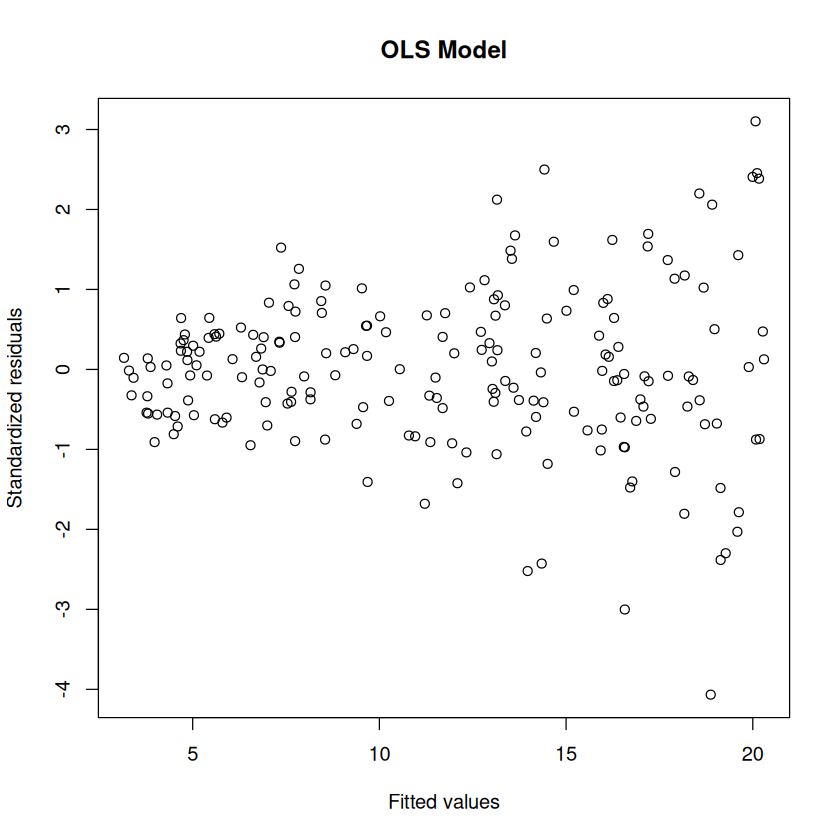

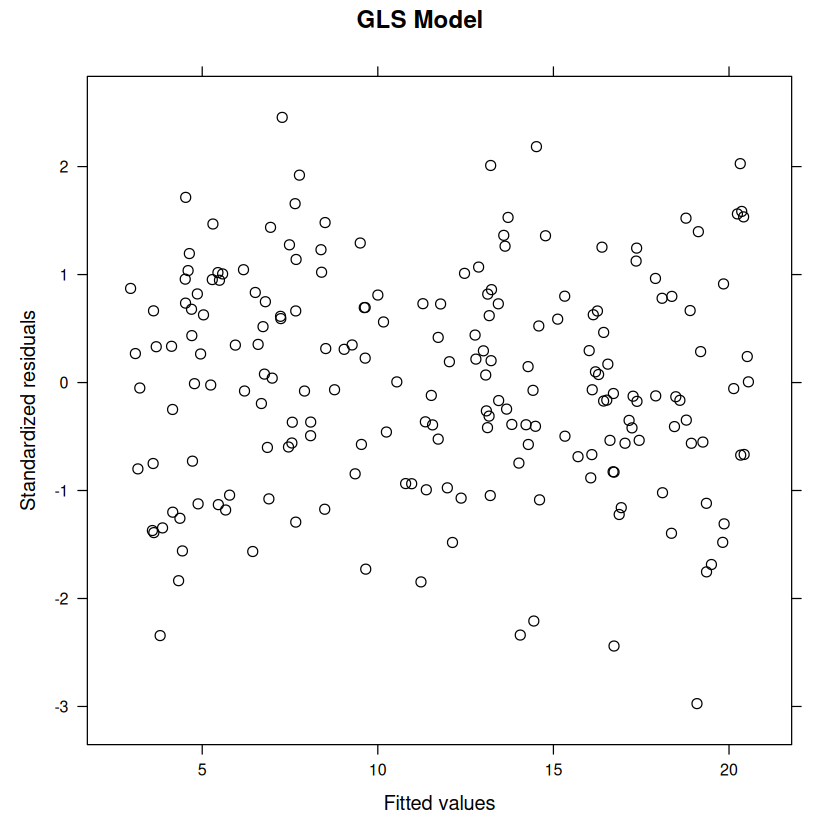

In [18]:
plot(fitted(uneq.var.mod), 
     rstandard(uneq.var.mod),
     xlab="Fitted values",
     ylab="Standardized residuals",
     main="OLS Model")

plot(gls.mod, col="black", grid=FALSE,
     main="GLS Model")

#### GLS for Multiple Regression
When we have *multiple* predictor variables, things get more tricky. Because the funnel shape in the diagnostic plots relates to the *fitted values*, this does not immediately indicate which of the predictors is contributing to the heteroscedasticity. When this is the case, we would ideally create some new scale-location plots with each predictor on the $x$-axis. As an example, let us simulate the data again, but this time the heteroscedasticity only relates to one variable and not the other

In [19]:
set.seed(666)

n      <- 200             # 200 simulated values
x.1    <- runif(n,1,10)   # random predictor 1 values 
x.2    <- runif(n,50,100) # random predictor 2 values
beta.0 <- 1               # population intercept
beta.1 <- 2               # population slope 1
beta.2 <- 0.2             # population slope 2
sigma  <- 0.5             # population baseline variance
delta  <- 0.8             # population exponent

# simulate increasing variance with x.1
sd.x    <- sigma * abs(x.1)^delta 
y       <- beta.0 + beta.1*x.1 + beta.2*x.2 + rnorm(n, mean=0, sd=sd.x)
sim.dat <- data.frame("x1.sim"=x.1, "x2.sim"=x.2, "y.sim"=y)

Now we can fit the OLS model and look at the scale-location plot

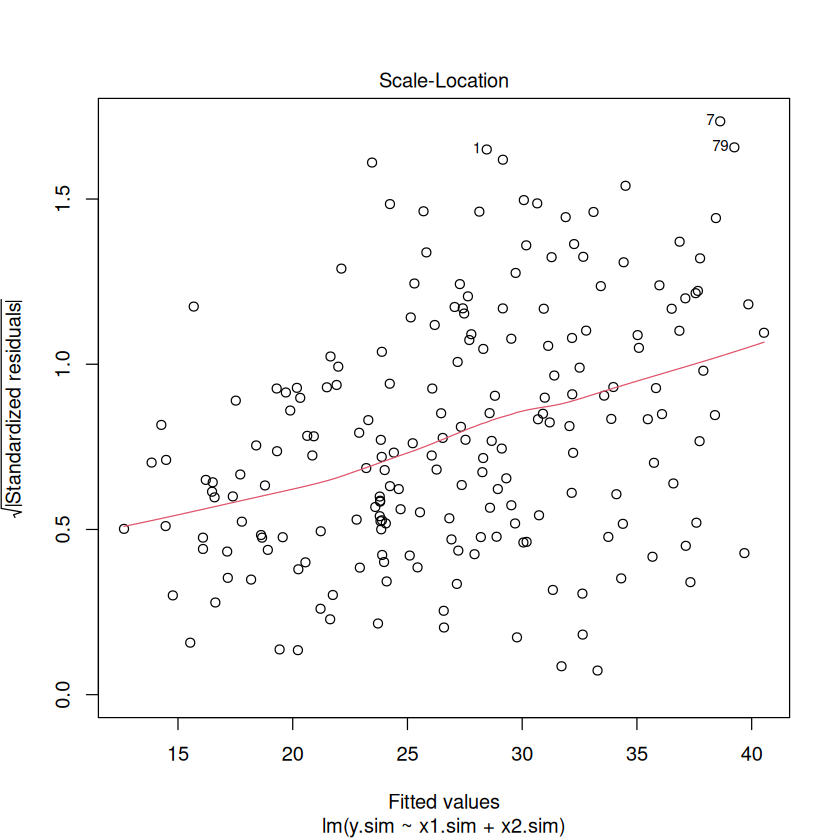

In [20]:
mod <- lm(y.sim ~ x1.sim + x2.sim, data=sim.dat)
plot(mod, which=3)

To try and work out how individual predictors are contributing, we can make some custom scale-location plots using each predictor on the $x$-axis

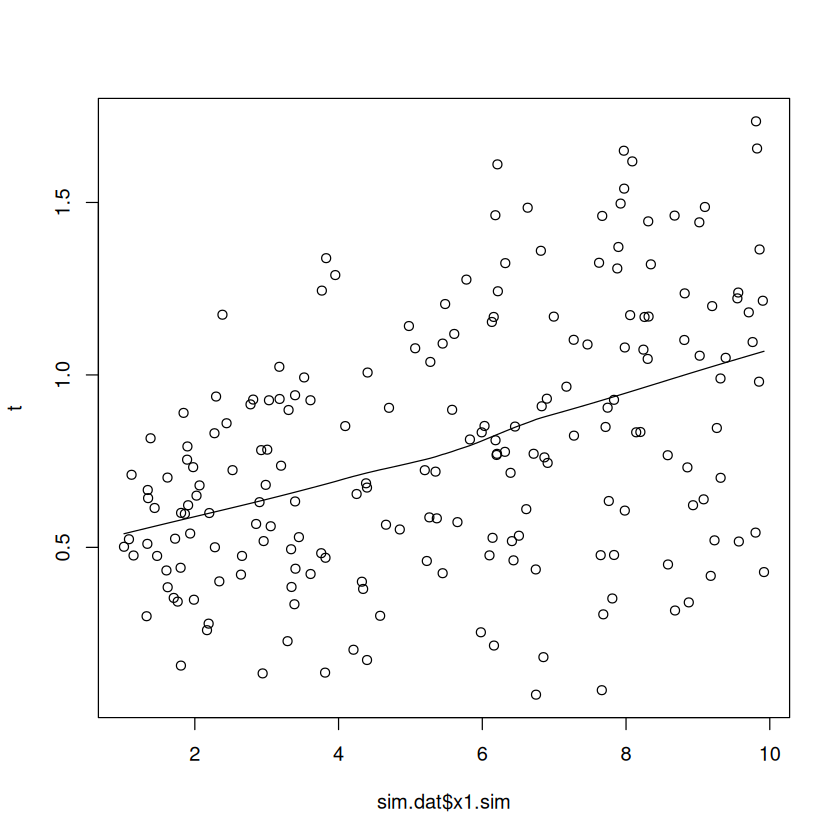

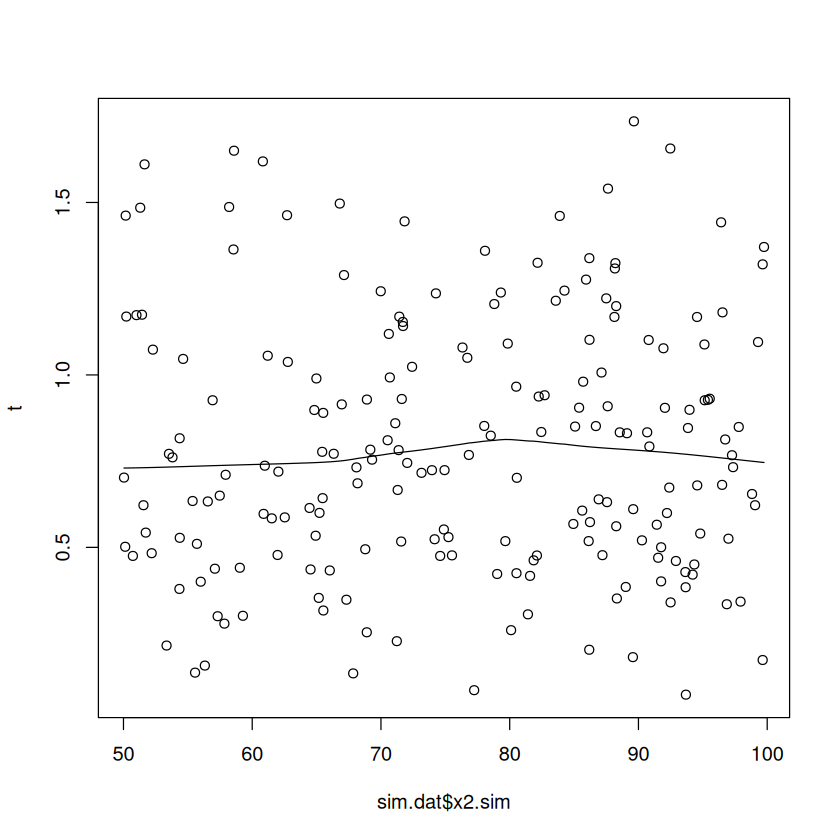

In [ ]:
std.resid <- sqrt(abs(rstandard(mod)))
plot(sim.dat$x1.sim,std.resid); lines(lowess(sim.dat$x1.sim,std.resid ))
plot(sim.dat$x2.sim,std.resid); lines(lowess(sim.dat$x2.sim,std.resid ))

If we see structure here, then this can inform us which predictor needs a variance model. We can see this above for the first predictor and not the second. If we saw a pattern in *both* plots above, we can use the `varComb()` function to combine two separate variance functions, one for each predictor. This would give

Generalized least squares fit by REML
  Model: y.sim ~ x1.sim + x2.sim 
  Data: sim.dat 
       AIC      BIC    logLik
  806.8394 826.5387 -397.4197

Combination of variance functions: 
 Structure: Power of variance covariate
 Formula: ~x1.sim 
 Parameter estimates:
    power 
0.8276013 
 Structure: Power of variance covariate
 Formula: ~x2.sim 
 Parameter estimates:
     power 
-0.3074363 

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 1.5224036 0.4684831  3.24964  0.0014
x1.sim      1.9761223 0.0451170 43.79993  0.0000
x2.sim      0.1932431 0.0062281 31.02741  0.0000

 Correlation: 
       (Intr) x1.sim
x1.sim -0.087       
x2.sim -0.940 -0.197

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.558415120 -0.625093717 -0.008225106  0.691017109  2.316949740 

Residual standard error: 1.805031 
Degrees of freedom: 200 total; 197 residual

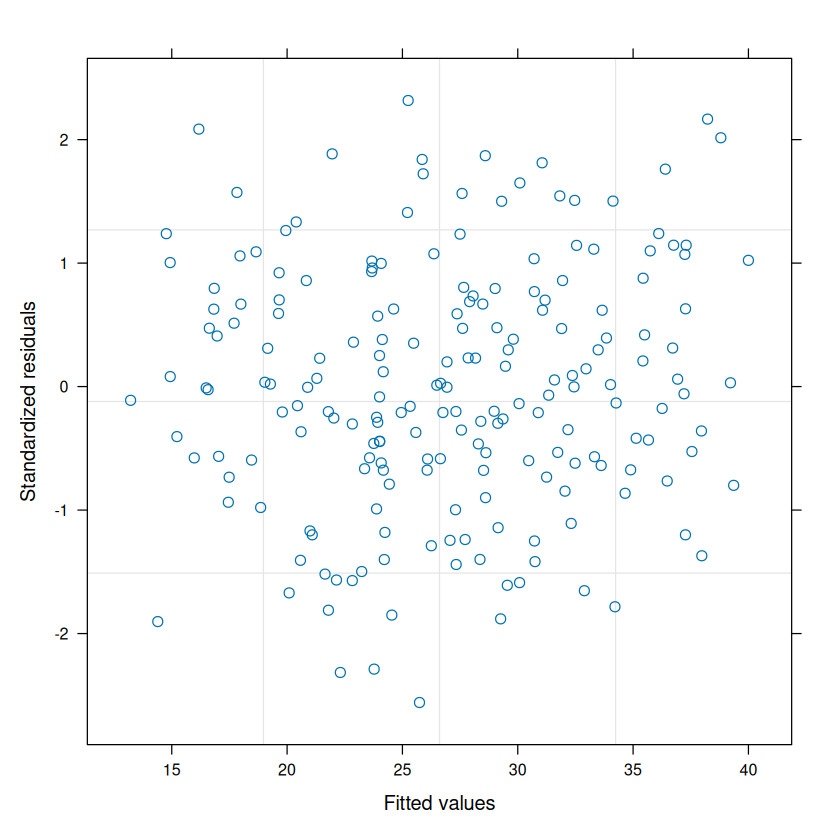

In [22]:
gls.mod <- gls(y.sim ~ x1.sim + x2.sim, data=sim.dat, weight=varComb(varPower(form= ~ x1.sim),
                                                                     varPower(form= ~ x2.sim)))
summary(gls.mod)
plot(gls.mod)

Notice that this has *not* resulted in $\hat{\delta}_{2} = 0$, even though there is not heteroscedasticity associated with the second predictor. This is important because GLS can easily *over-fit* a variance function and adjust the data to remove something that is not there. This will bias the results. As such, we have to use these functions carefully and not just try and model everything. In addition, much like with robust regression, the inferential tests here need to be treated cautiously and only as *asymptotically correct*.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY 9</b> Can you adapt the code above to use GLS with the `mtcars` dataset? 
</div>

### Non-parametric Resampling for Non-normality
As our final method, we turn to ways of dealing with depatures from normality. Now, as argued elsewhere, normality is one of those assumptions that often matters less than people think. We have demonstrated previously how variable even true samples from a normal distribution can appear, especially in small samples. We have also made it clear that normality only matters in terms of making sure the $p$-values have the assumed null distribution. Under large samples, the central limit theorem indicates that the sampling distributions of the parameters will be normal, even when the population distribution is not. So, in reality, normality only matters when we want to perform inference *and* when the sample size is small. 

Nevertheless, it does not always feel very comfortable to wave this assumption to one side. This is particularly true when we have outliers that create heavier tails than we would expect from a normal distribution, or if we are using data that we know cannot *really* come from a normal distribution (such as questionnaire scores). In these cases, we can turn to *non-parametric* approaches. As the name implies, non-parametric statistics are not concerned with estimating parameters from a probability distribution. As such, they make no assumptions about the distributional form of the data.

The use of non-parametric statistics with psychology is usually constrained to very old approaches such as the Kruskall-Wallace test or the Friedman ANOVA. These methods have not been a part of modern statistics for a very long time. Instead, since the advent of computers, modern statistics has made use of non-parametric *resampling* approaches to these problems. These methods involve using the sample as a proxy for the population and then repeatedly *resampling* to build the distributions needed for inference. This include methods such as the *bootstrap*, *jackknife* and the *permutation test*. If our interest is calculating a $p$-value, the permutation approach is the easiest method to use. If you want confidence intervals, the *bootstrap* is the method to choose. We will only focus on permutation tests here.

In brief, the permutation approach proceeds as follows:

- On each iteration, the outcome variable is randomly reordered to break any relationship between the outcome and the predictor variables
- The model is refit on the reordered (*permuted*) data and the parameter estimates saved
- This is repeated thousands of times to create a realisation of the sampling distribution under the null hypothesis of *no relationship* between the outcome and the predictors
- Once this distribution had been built, $p$-values can be calculated from it

So, in effect, we are using the data to simulate the null distribution and then calculating $p$-values from it, rather than deriving it from theory. This allows us to use $p$-values that make *no assumptions* about the population distribution.

To do this in `R`, we can make use of the `lmPerm` package, which contains the `lmp()` function. This is essentially identical to `lm()`, except that the $p$-values are calculated using permutations rather than theory. We can see an example below.

In [23]:
library(lmPerm)
perm.mod <- lmp(mpg ~ wt + hp + cyl, data=mtcars)
summary(perm.mod)

[1] "Settings:  unique SS : numeric variables centered"



Call:
lmp(formula = mpg ~ wt + hp + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9290 -1.5598 -0.5311  1.1850  5.8986 

Coefficients:
    Estimate Iter Pr(Prob)    
wt  -3.16697 5000   <2e-16 ***
hp  -0.01804  540    0.157    
cyl -0.94162  792    0.112    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.512 on 28 degrees of freedom
Multiple R-Squared: 0.8431,	Adjusted R-squared: 0.8263 
F-statistic: 50.17 on 3 and 28 DF,  p-value: 2.184e-11 


There are a few of things to note here. Firstly, to make the permutations easier to calculate, all variables are centered and the intercept is removed. Secondly, no test statistics are reported because they are not needed. Similarly, no standard errors are reported because the width of the sampling distribution is part of what is simulated across permutes of the data. So, we now have $p$-values derived from a simulated null distribution that does not depend upon assuming any population distribution for the data.

### Manual Permutations
Just to make the permutation framework clearer, we provide code below that shows how to do this manually for the parameter associated with `hp`. We first remove the effects of the other predictors from both `mpg` and `hp`. Then, across 5,000 permutations, we randomly reshuffle `mpg`, fit the model and save the slope estimate. At the end, we can view the simulated sampling distribution of `wt`, under the null hypothesis of no relationship.

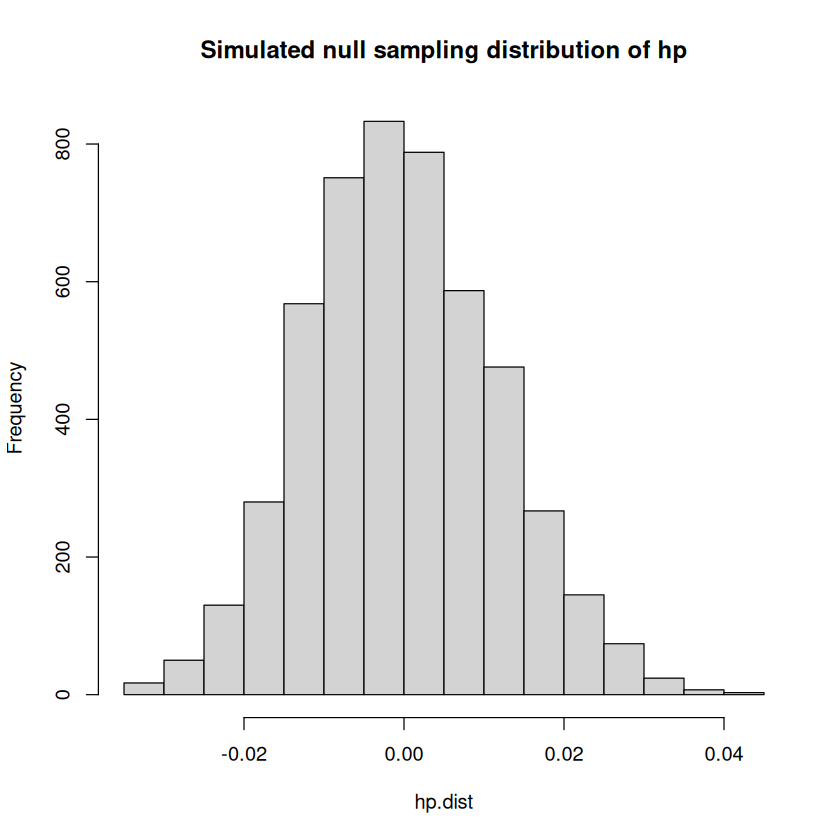

In [24]:
mpg.adj <- resid(lm(mpg ~ wt + cyl, data=mtcars))
hp.adj  <- resid(lm(hp  ~ wt + cyl, data=mtcars))

hp.coef <- coef(lm(mpg.adj ~ hp.adj))[2] # original slope

n.perms    <- 5000
hp.dist    <- rep(0,n.perms) # slope null distribution
hp.dist[1] <- hp.coef
for (i in 2:n.perms){
    mpg.adj.p  <- sample(mpg.adj)         # permute mpg
    mod.p      <- lm(mpg.adj.p ~ hp.adj)  # permuted model
    hp.dist[i] <- coef(mod.p)[2]          # save slope
}

hist(hp.dist, main="Simulated null sampling distribution of hp")

As the final step, we can find out from this distribution what the probability of achieving the slope value of the un-permuted model is. This gives us our non-parameteric $p$-value.

In [25]:
nonparam.p <- 2 * mean(hp.dist >= abs(hp.coef))
print(nonparam.p)

[1] 0.136


This is slightly different to value produced by `lmp()`. In part this is because it will change every time due to the randomness of the resampling. In addition, `lmp()` has a more sophisticated method for deriving the permutation distributions than our brute-force approach above. For this example, `lmp()` is able to calculate the exact number of possible permutations and only run those exhaustively, rather than just running 5,000 like we did above. So, in general, we should just trust what `lmp()` is reporting, but hopefully the code above makes the method clearer.

### What About Multicollinearity?
We have now covered several methods that can be used when assumptions appear violated. One assumption we have yet to mention is multicollinearity. Although you will sometimes read that an approach called *ridge regression* can be used, we will not be recommending this. Ridge regression is a method that *biases* the parameter estimates as a means of stabilising them under multicollinearity. The aim is for a *stable model*, rather than one that is an accurate estimate of the population. This has more applications as a predictive model in *machine learning*, rather than an inferential model. As such, the bias is seen as less of a problem. However, if we are trying to say something accurate about a population, having bias is *not* a good thing. Neither is the fact that inference becomes very difficult to perform. Indeed, most ridge regression implementations will not provide any tests on the coefficients. So, it is for these reasons that ridge regression is *not* recommended. Generally, the only solution for multicollinearity is to limit the predictors included in the model. After all, if two predictors are correlated enough to cause problems of multicollinearity, then they are measuring *very similar* phenomena and a clearer conceptual argument needs to be made around why *both* are even necessary. It may well be that the problem you are trying to solve is simply ill-posed. In a way, you are trying to answer a question that the data cannot answer. From this perspective, multicollinearity is not a model error that we can fix, it is a *model criticism*. If you have multicollinearity, it tells you that there is something fundamentally wrong with your view of the problem. This is what needs to be fixed, not the model.

### What About Multiple Violations?
Finally, we need to consider what to do if *multiple* assumptions appear to be violated. Unfortunately, all the methods above really only tackle a single violation at a time. Sticking with these approaches, all we can do is select the *dominant* violation to fix and then accept that the rest of the violations remain in place. A good rule-of-thumb is to work through a model by

1. Fixing structural issues with the model form first (anything related to the mean or variance function).
2. Only worry about distributional assumptions second (anything related to outliers or the distributional form).

So, what we need to do is address assumption violations in a logical order based on how much they affect the model.
First, we sort out the mean function. If the relationship is non-linear, we fix that using transformations or a polynomial model. If there is multicollinearity, we must identify it and respecify the model to remove it. This step must come first, because nothing else works properly until the mean is correctly specified.

Once the mean is sorted, we examine the variance function. If there is heteroscedasticity, we use GLS with an appropriate variance function. GLS is our main tool here, and it takes priority over other fixes.

After handling structural issues, we consider outliers. If we are using OLS regression, we can switch to a robust method, which automatically down-weights outliers. If we are using GLS, robust methods are not available, so the practical option is careful removal based on diagnostics.

Finally, we assess the distributional assumptions. If we have not used GLS or robust methods, permutation tests give us valid, distribution-free $p$-values. If we have used GLS or a robust model, permutation is harder to apply, so instead we judge how severe the remaining distributional violation is and adjust our confidence in the $p$-values accordingly.

# Summary
In this workshop, we have covered a variety of topics around model assumptions and diagnostics. To begin with, we saw some useful additional plots that can help in exploring and diagnosing problems with the data. We then looked at how the mean function can be adjusted using polynomial regression, for cases where the fit is clearly non-linear. After that, we examined alternative models that allow flexibility in the face of severe violations. This included robust regression, GLS and permutation methods. No single one of these is a panacea and our ability to combine them is limited. However, knowing about them will allow you to make the best decision you can about how to deal with data that will not behave itself. These are just more tools in your data analysis toolkit and are more than many experimental psychologists and cognitive neuroscientists know about.

<div class="alert alert-block alert-warning"> 
<b>TEST QUESTIONS</b> 

Use the questions below to check your understanding of all the materials from this week.

1. What issues can arise using inferential tests of assumptions in both small and large samples?
2. What are the 5 core assuptions of linear regression?
3. What is the distinction between an observation that is an *outlier* and an observation that has *high leverage*?
4. Why is assessing homoscedasticity using the *raw* residuals a bad idea?
5. What is the difference between *standardised* and *studentised* residuals?
6. What two diagnostic features does Cook's distance combine?
7. Which data feature does the VIF help you diagnose?
8. Why are the labelled points in the diagnostic plots from `lm()` not necessarily indicative of any problems?
9. What is the key difference between the Box-Cox and the Box-Tidwell transformation?
10. Conceptually, what is the core difference between transforming the outcome to correct for non-linearity and using a polynomial regression model?
</div>